In [1]:
import os
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import zipfile

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Extract dataset
zip_path = "/content/drive/MyDrive/Grad/Balanced Palm.zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction completed!")

# Define paths
train_dir = "/content/dataset/Balanced Palm/train"
test_dir = "/content/dataset/Balanced Palm/test"
categories = ["AnemicP", "Non-AnemicP"]

Mounted at /content/drive
Extraction completed!


In [3]:
# Function to check if a file is an image
def is_image_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    return filename.lower().endswith(valid_extensions)

# Function to load images and labels
def load_images(folder, target_size=(128, 128)):
    images, labels = [], []
    class_dict = {}
    class_index = 0

    for main_folder in [train_dir, test_dir]:
        if os.path.exists(main_folder):
            for class_name in os.listdir(main_folder):
                class_folder = os.path.join(main_folder, class_name)
                if os.path.isdir(class_folder):
                    if class_name not in class_dict:
                        class_dict[class_name] = class_index
                        class_index += 1
                    for filename in os.listdir(class_folder):
                        if is_image_file(filename):
                            img_path = os.path.join(class_folder, filename)
                            img = cv2.imread(img_path)
                            if img is not None:
                                img = cv2.resize(img, target_size)
                                images.append(img)
                                labels.append(class_dict[class_name])

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images, labels, class_dict

# Load dataset
X, y, class_map = load_images(extract_path)

In [4]:
# Extract color histogram features
def extract_color_histogram(images, bins=(8, 8, 8)):
    features = []
    for img in images:
        img = (img * 255).astype(np.uint8)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)
    return np.array(features)

X_features = extract_color_histogram(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f"{model_name} Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"{model_name} Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")

    print(f"\n{model_name} Classification Report (Train):\n", classification_report(y_train, y_pred_train))
    print(f"\n{model_name} Classification Report (Test):\n", classification_report(y_test, y_pred_test))

    plt.figure(figsize=(8, 4))
    plt.bar(["Train", "Test"], [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)], color=['#5f7d95', '#A5b7c5'])
    plt.title(f"{model_name} Accuracy")
    plt.ylabel("Accuracy")
    plt.show()

# Train Random Forest Model

Random Forest Train Accuracy: 0.9991
Random Forest Test Accuracy: 0.9954

Random Forest Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2355
           1       1.00      1.00      1.00      1998

    accuracy                           1.00      4353
   macro avg       1.00      1.00      1.00      4353
weighted avg       1.00      1.00      1.00      4353


Random Forest Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       615
           1       0.99      1.00      0.99       474

    accuracy                           1.00      1089
   macro avg       0.99      1.00      1.00      1089
weighted avg       1.00      1.00      1.00      1089



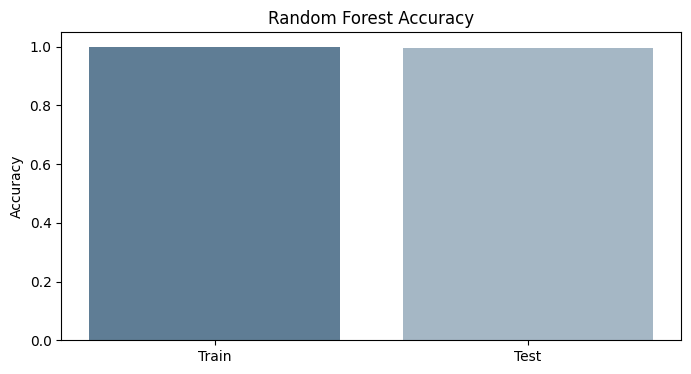

['RF-balancedPalm.pkl']

In [5]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")
joblib.dump(rf_model, "RF-balancedPalm.pkl")

# Train XGBoost Model


XGBoost Train Accuracy: 0.9991
XGBoost Test Accuracy: 0.9945

XGBoost Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2355
           1       1.00      1.00      1.00      1998

    accuracy                           1.00      4353
   macro avg       1.00      1.00      1.00      4353
weighted avg       1.00      1.00      1.00      4353


XGBoost Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       615
           1       0.99      1.00      0.99       474

    accuracy                           0.99      1089
   macro avg       0.99      0.99      0.99      1089
weighted avg       0.99      0.99      0.99      1089



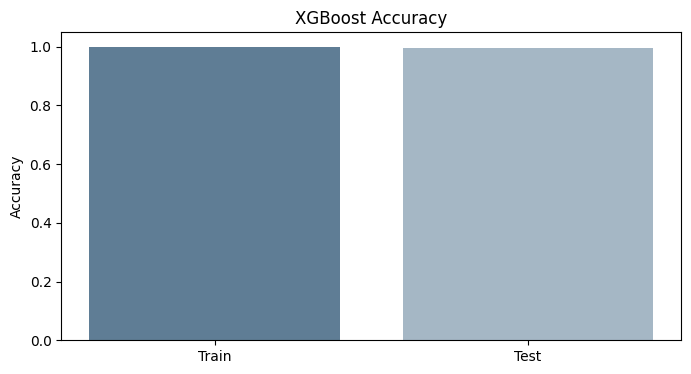

['XGB-balancedPalm.pkl']

In [6]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=0.1, reg_lambda=1.0, reg_alpha=0.5, random_state=42)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
joblib.dump(xgb_model, "XGB-balancedPalm.pkl")

# Hyperparameter tuning for XGBoost


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.9; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=8, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END 

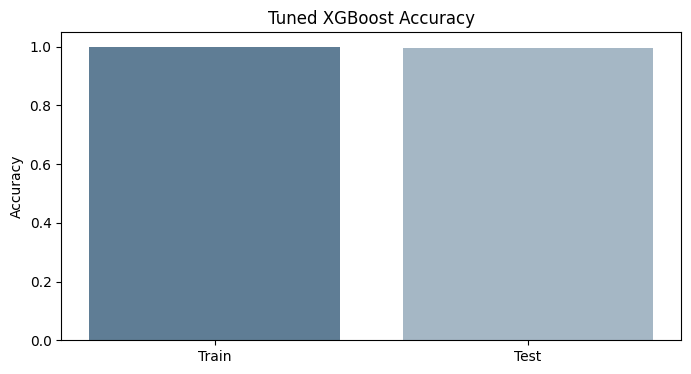

['XGB-Tuned-balancedPalm.pkl']

In [7]:
# Hyperparameter tuning for XGBoost
grid_search = GridSearchCV(
    XGBClassifier(random_state=42),
    {
        'max_depth': [8, 10, 12],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [200, 300, 400],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    cv=3, scoring='accuracy', n_jobs=1, verbose=2
)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
evaluate_model(best_xgb, X_train, X_test, y_train, y_test, "Tuned XGBoost")
joblib.dump(best_xgb, "XGB-Tuned-balancedPalm.pkl")

# Train Decision Tree Model


Decision Tree Train Accuracy: 0.9991
Decision Tree Test Accuracy: 0.9899

Decision Tree Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2355
           1       1.00      1.00      1.00      1998

    accuracy                           1.00      4353
   macro avg       1.00      1.00      1.00      4353
weighted avg       1.00      1.00      1.00      4353


Decision Tree Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       615
           1       0.99      0.99      0.99       474

    accuracy                           0.99      1089
   macro avg       0.99      0.99      0.99      1089
weighted avg       0.99      0.99      0.99      1089



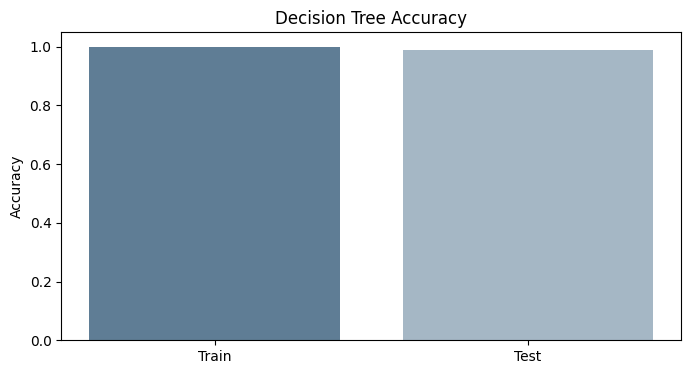

['DT-balancedPalm.pkl']

In [8]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree")
joblib.dump(dt_model, "DT-balancedPalm.pkl")

In [10]:
!cp RF-balancedPalm.pkl /content/drive/MyDrive/


In [11]:
!cp XGB-Tuned-balancedPalm.pkl /content/drive/MyDrive/
!cp XGB-balancedPalm.pkl /content/drive/MyDrive/
!cp DT-balancedPalm.pkl /content/drive/MyDrive/
